In [ ]:
!pip install open3d
import os
from pathlib import Path
import cv2
import copy
from functools import cached_property

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: werkzeug
    Found existing installa

Mounted at /content/drive


In [ ]:
class CustomPLY:
    def __init__(self, ply_path):
        self.ply_path = ply_path
        self.ply = o3d.io.read_point_cloud(self.ply_path)
        self.ply.estimate_normals()

        self.mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
            size=1,
            origin=[0, 0, 0]
        )

    def radius(self):
        distances = self.ply.compute_nearest_neighbor_distance()
        avg_dist = np.mean(distances)
        # radius = 3 * avg_dist
        # print("radius:", radius)
        return avg_dist

    def down_sampling(self, coef=1., overwrite=True, preview=True):
        ply_uniformed = self.ply.voxel_down_sample(voxel_size=self.radius() * coef)

        if overwrite:
            self.ply = ply_uniformed

        if preview:
            o3d.visualization.draw_geometries([ply_uniformed, self.mesh_frame])

        return ply_uniformed

    def squeeze_to_z(self, overwrite=True, preview=True):
        for p in self.ply.points:
            p[2] = 0

    def move_center(self):
        self.ply.translate([0, 0, 0], relative=False)

    def scale(self, scale):
        self.ply.scale(scale, center=self.ply.get_center())

    def sort(self):
        # ply.ply.points = a[a[:, 0].argsort()]
        pass

    def slice(self, threshold, overwrite=True, preview=False):
        """
        :param threshold: percentage from z_min
        """
        assert 0 < threshold < 1
        ply_np = np.asarray(self.ply.points)
        z_min = ply_np[:, 2].min()
        z_max = ply_np[:, 2].max()
        z_threshold = (z_max - z_min) * threshold

        ply_sliced = self.ply.select_by_index(np.where(ply_np[:, 2] < z_min + z_threshold)[0])

        print(self.ply)
        print(ply_sliced)
        print(1, z_min + z_threshold)

        if preview:
            o3d.visualization.draw_geometries([ply_sliced, self.mesh_frame])
        if overwrite:
            self.ply = ply_sliced

    def show_range_coords(self):
        ply_np = np.asarray(self.ply.points)
        print()
        for i in range(3):
            print(
                ply_np[:, i].min(),
                ply_np[:, i].max(),
                "range:",
                ply_np[:, i].max() - ply_np[:, i].min()
            )

    def align_to_z(self, z_=-1, overwrite=False, preview=False):
        plane_model, inliers = self.ply.segment_plane(
            distance_threshold=self.radius,
            ransac_n=1000,
            num_iterations=1000
        )
        [a, b, c, d] = plane_model
        print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

        plane_n = np.array([a, b, c])
        plane_z = np.array([0, 0, z_])

        vec1 = np.reshape(plane_n, (1, -1))
        vec2 = np.reshape(plane_z, (1, -1))

        from scipy.spatial.transform import Rotation as R
        r = R.align_vectors(vec2, vec1)
        rot = r[0].as_matrix()

        ply_aligned = copy.deepcopy(self.ply)
        ply_aligned.rotate(rot, center=ply_aligned.get_center())

        if preview:
            o3d.visualization.draw_geometries([self.ply, ply_aligned, self.mesh_frame])

        if overwrite:
            self.ply = ply_aligned

        return ply_aligned

    def elevation_map(self, overwrite=False, preview=False):
        ply_np = np.asarray(self.ply.points)

        x_range = ply_np[:, 0].max() - ply_np[:, 0].min()
        y_range = ply_np[:, 1].max() - ply_np[:, 1].min()

        z_min = ply_np[:, 2].min()
        z_max = ply_np[:, 2].max()
        z_range = z_max - z_min

        if not min(x_range, y_range, z_range) == z_range:
            raise Exception("not aligned with z axis")

        new_colors = []
        for point in ply_np:
            new_colors.append([0, (point[2] - z_min) / z_range, 0])
            # new_colors.append([0.5, 0, 0])

        ply.colors = o3d.utility.Vector3dVector(
            np.array(new_colors)
        )
        ply_new = o3d.geometry.PointCloud()

        ply_new.points = o3d.utility.Vector3dVector(ply_np)
        ply_new.colors = o3d.utility.Vector3dVector(np.array(new_colors))

        if preview:
            o3d.visualization.draw_geometries([ply_new, self.mesh_frame])
        if overwrite:
            self.ply = ply_new

        return ply_new

    def erosion(self, overwrite=False, preview=False):
        print("Apply erosion")
        ply_np = np.asarray(self.ply.points)

        radius = self.radius() * 2
        filtered_indexes = []
        for ind, point in enumerate(ply_np):

            distances = np.linalg.norm(ply_np - point, axis=1)
            indices = np.where(distances <= radius)
            # print(np.mean(distances))
            points_around = ply_np[indices]
            # print(points_around.shape, len(indices))
            points_around_centroid = np.mean(points_around, axis=0)

            distance_with_centroid = np.linalg.norm(point - points_around_centroid)
            if distance_with_centroid <= radius * .1:
                filtered_indexes.append(ind)

        points_filtered = ply_np[filtered_indexes]

        ply_new = o3d.geometry.PointCloud()
        ply_new.points = o3d.utility.Vector3dVector(points_filtered)

        if preview:
            o3d.visualization.draw_geometries([ply_new])

        if overwrite:
            self.ply = ply_new

    def detect_crossroads(self, overwrite=False, preview=False):
        ply_np = np.asarray(self.ply.points)
        r_ = self.radius()

        filtered_indexes = []
        for ind, point in enumerate(ply_np):

            distances = np.linalg.norm(ply_np - point, axis=1)
            indices = np.where(distances <= r_ * 10)
            points_around = ply_np[indices]
            points_around_centroid = np.mean(points_around, axis=0)
            distance_with_centroid = np.linalg.norm(point - points_around_centroid)
            print(points_around.shape, distance_with_centroid)
            if distance_with_centroid > r_ * 3:
                filtered_indexes.append(ind)

        points_filtered = ply_np[filtered_indexes]
        ply_new = o3d.geometry.PointCloud()
        ply_new.points = o3d.utility.Vector3dVector(points_filtered)

        if preview:
            o3d.visualization.draw_geometries([ply_new])

        if overwrite:
            self.ply = ply_new

    def iter_points_around(self, radius, indexes=None):
        ply_np = np.asarray(self.ply.points)
        for ind, point in enumerate(ply_np):
            if indexes:
                if ind not in indexes:
                    continue
            distances = np.linalg.norm(ply_np - point, axis=1)
            indices = np.where(distances <= radius)
            points_around = ply_np[indices]
            yield ind, point, points_around

    def dataset(self, indexes, r_=None, preview=False):
        self.ply.translate([
            # ply_np[:, 0].max(),
            # ply_np[:, 1].max(),
            # ply_np[:, 2].max()
            100, 100, 100
        ], relative=False)

        if r_ is None:
            r_ = self.radius() * 20
        dt = []

        for ind, point, points_around in self.iter_points_around(r_, indexes):
            z = (
                int(points_around[:, 0].max() - points_around[:, 0].min()),
                int(points_around[:, 1].max() - points_around[:, 1].min()),
            )
            # print(z)
            image = np.zeros(z)
            points_around_x_min = int(points_around[:, 0].min())
            points_around_y_min = int(points_around[:, 1].min())

            for point_around in points_around:
                # print(int(point_around[0]), int(point_around[1]))
                image[
                    int(point_around[0]) - (points_around_x_min + 2),
                    int(point_around[1]) - (points_around_y_min + 2)
                ] = 255



            cv_image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR)
            resized_image = cv2.resize(cv_image, (20, 20))

            # kernel = np.ones((2, 2), np.uint8)
            # resized_image = cv2.dilate(resized_image, kernel, iterations=1)

            image = np.array(resized_image)

            # print(image.shape)
            dt.append(image)

            if preview:
                print(ind)
                plt.imshow(image)
                plt.show()

            # print(points_around.shape, points_around[:, 2].max())

        dt = np.stack(dt, axis=0)
        return dt

    def detect_crossroads_3(self, model, r_, threshold=0.5, overwrite=False, preview=False):
        ply_np = np.asarray(self.ply.points)
        num_of_points = ply_np.shape[0]
        print(num_of_points)
        indexes = [4*i for i in range(int((ply_np.shape[0]-2)/4))]

        x_t = self.dataset(indexes, r_)
        y_p = model.predict(x_t)
        y_p = y_p.reshape(y_p.shape[0])
        indexes = np.array(indexes)
        filtered_indexes = indexes[y_p > threshold]

        print(len(filtered_indexes))

        points_filtered = ply_np[filtered_indexes]
        ply_new = o3d.geometry.PointCloud()
        ply_new.points = o3d.utility.Vector3dVector(points_filtered)

        if overwrite:
            self.ply = ply_new

        return ply_new


    def save(self, name):
        output_path = Path(os.path.dirname(os.path.abspath(self.ply_path))) / name
        print("writing to:", output_path)
        o3d.io.write_point_cloud(str(output_path), self.ply)




-81.13799711303918 85.67450288696082 range: 166.8125
-76.10136783277241 68.89863216722759 range: 145.0
-11.236785264176856 -5.636782975358497 range: 5.6000022888183585
class crossroads
88


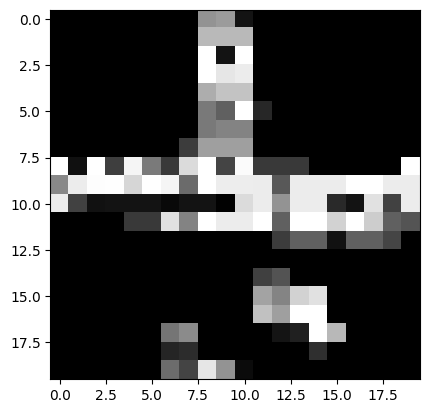

432


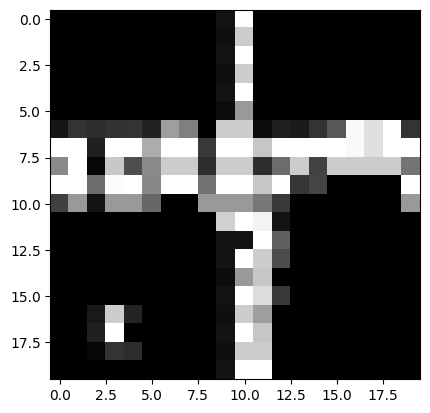

919


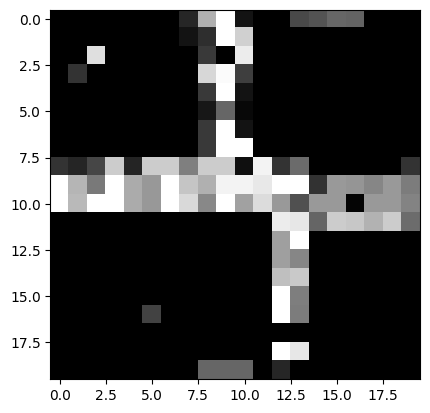

1513


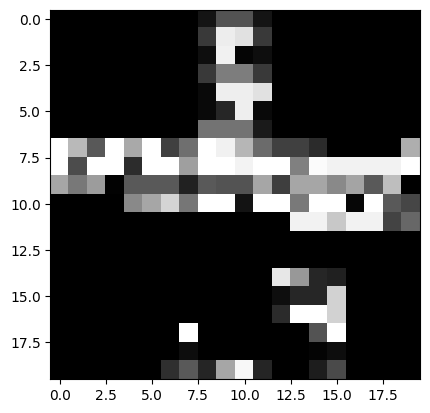

2124


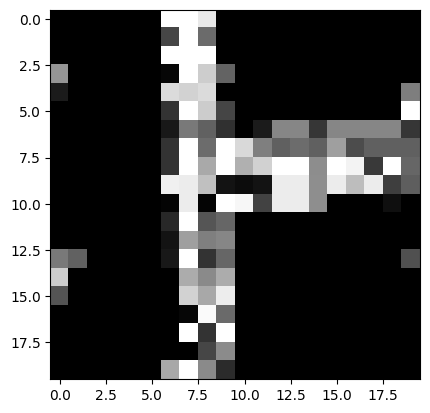

2491


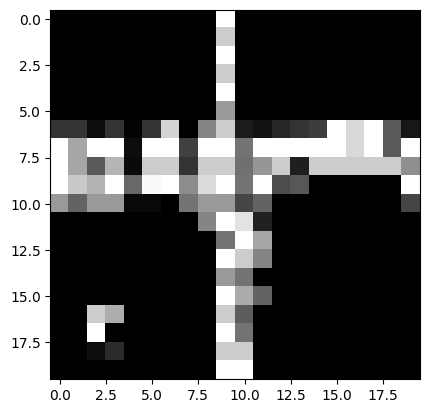

2581


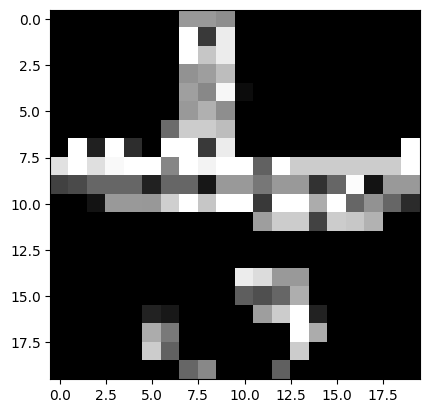

2624


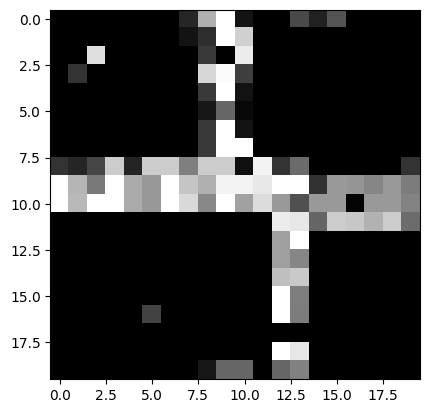

2811


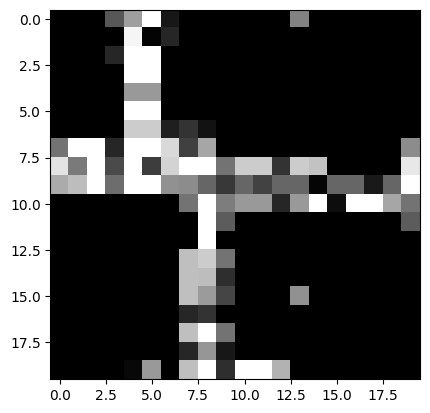

4511


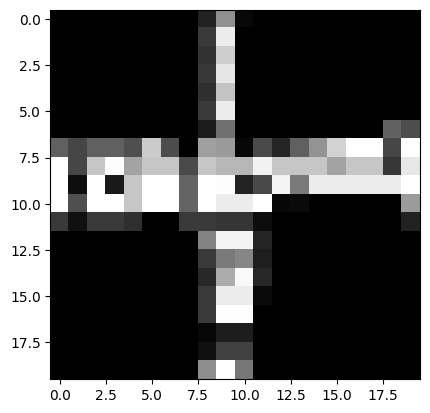

4513


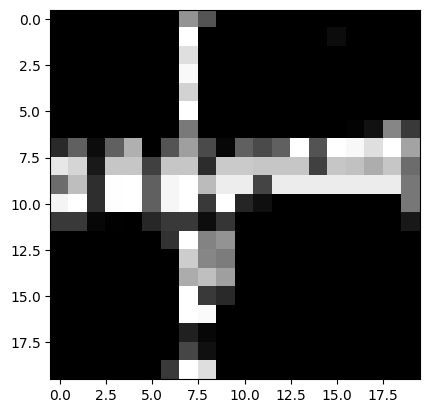

4607


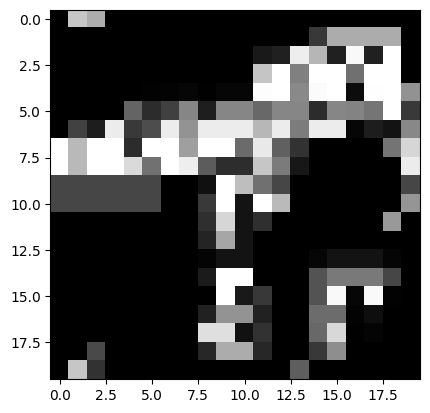

5681


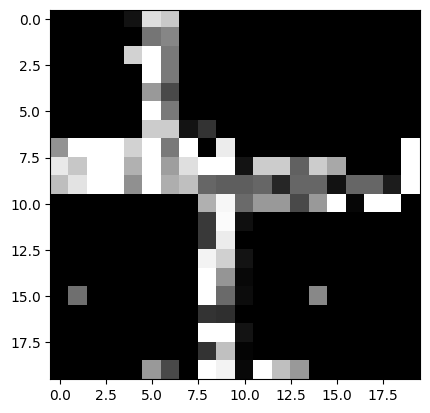

class non crossroads
156


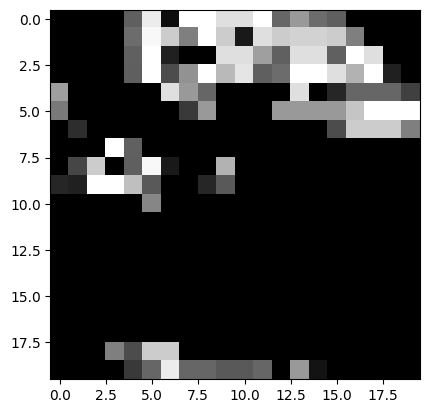

249


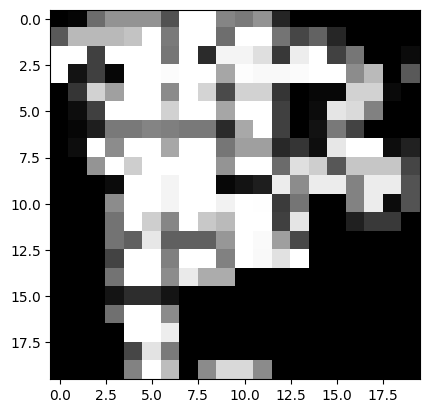

383


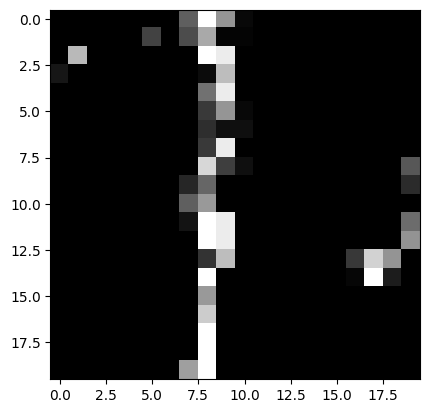

527


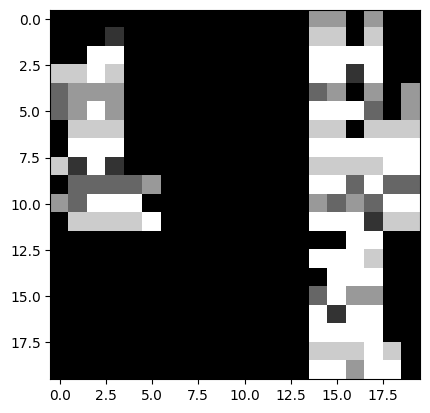

639


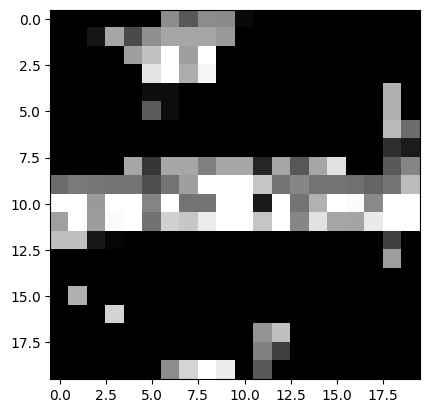

700


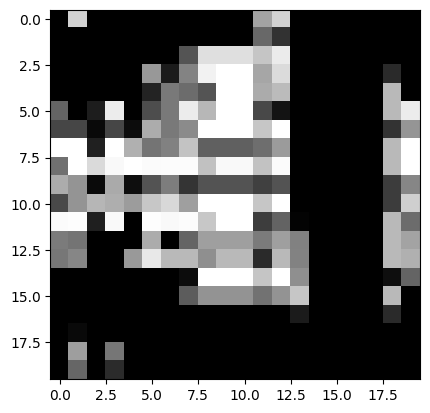

905


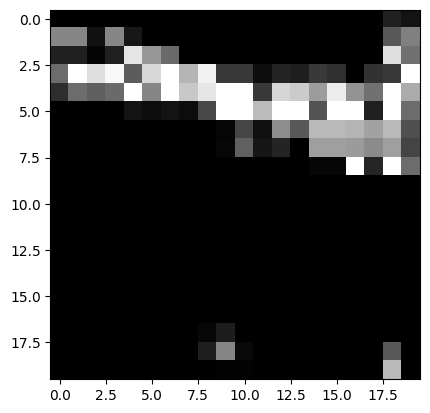

1015


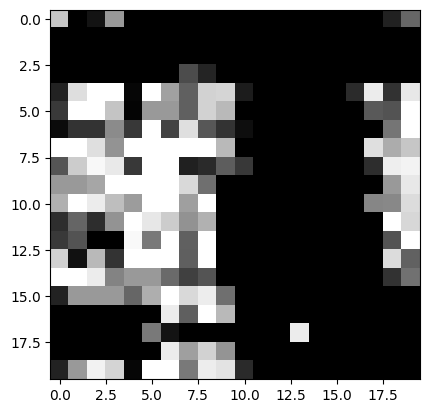

1300


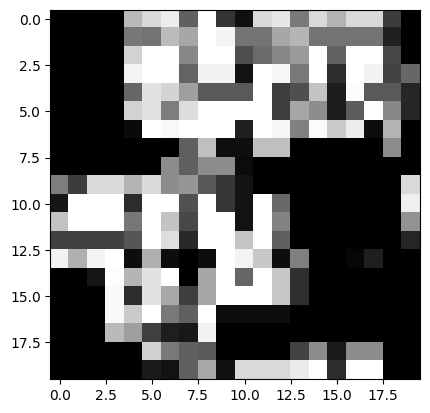

1357


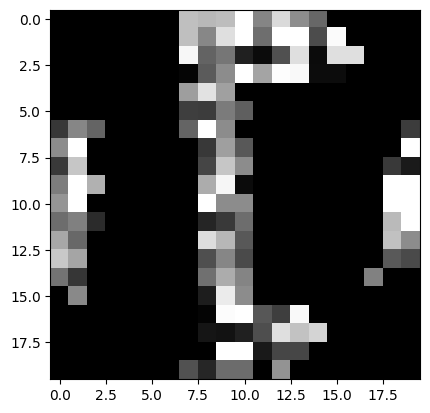

1955


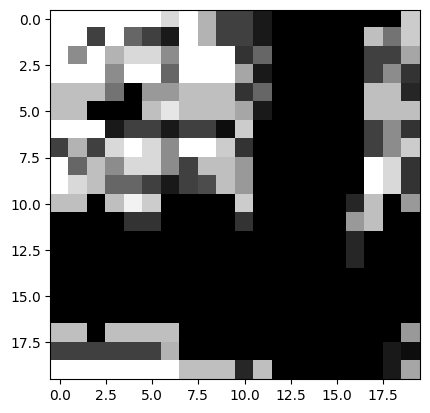

2135


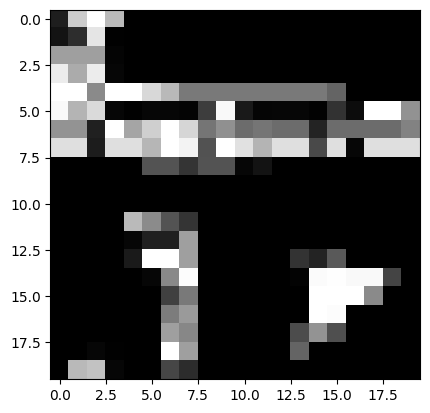

2400


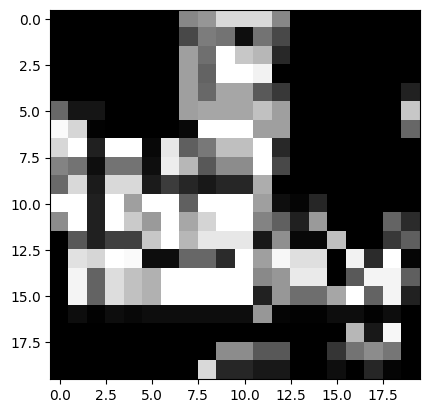

2953


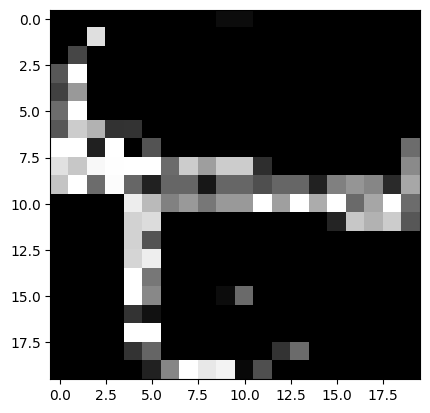

3173


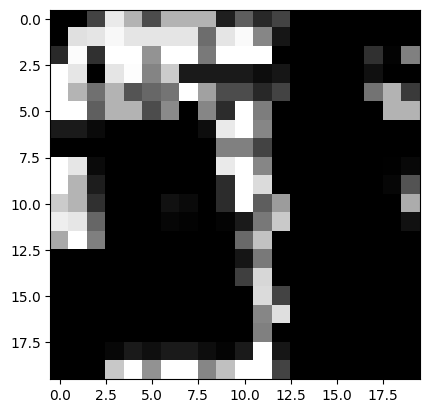

3306


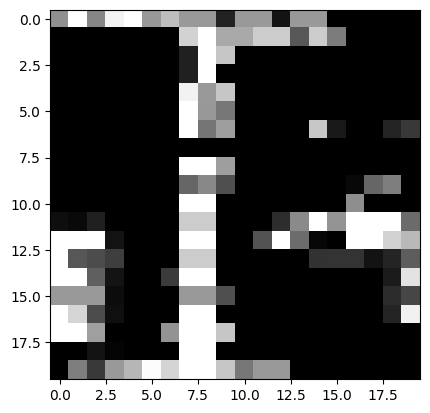

4280


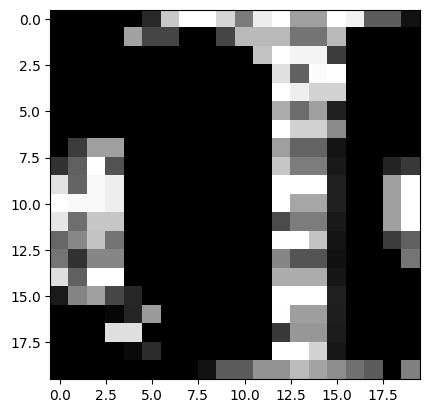

(13, 20, 20, 3)
(13, 20, 20, 3)
(13, 20, 20, 3)
(13, 20, 20, 3)
(13, 20, 20, 3)
(13, 20, 20, 3)
(13, 20, 20, 3)
(17, 20, 20, 3)
(17, 20, 20, 3)
(17, 20, 20, 3)
(17, 20, 20, 3)
(17, 20, 20, 3)
(17, 20, 20, 3)
(180, 20, 20, 3)
(180,)


In [ ]:
ply_path = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/ply_reg/color_pd30_8bit_small_street_4_3_3_ele_uniformed_sliced.ply"

indexes_1 = [
    2581,
    1513,
    88,
    4511,
    2491,
    4513,
    4607,
    5681,
    2811,
    2624,
    919,
    4511,
    432,
    2124
]
indexes_0 = [
    527,
    4280,
    905,
    1015,
    2953,
    3306,
    1357,
    639,
    383,
    3173,
    2400,
    1955,
    156,
    700,
    1300,
    249,
    2135
]

ply = CustomPLY(ply_path)
radius_ = ply.radius()*20

ply.show_range_coords()

print("class crossroads")
x_1 = ply.dataset(indexes_1, r_=radius_, preview=True)

print("class non crossroads")
x_0 = ply.dataset(indexes_0, r_=radius_, preview=True)

print(x_1.shape)

from keras.preprocessing.image import ImageDataGenerator
def gen_more(dt, n_max=3):
    datagen = ImageDataGenerator(
        rotation_range=45,
        horizontal_flip=True,
        vertical_flip=True,
    )
    datagen.fit(dt)

    train_x_1 = []
    n = 0
    for images in datagen.flow(dt, batch_size=128, ):
        print(images.shape)
        for img in images:
            train_x_1.append(img)
        n += 1
        if n > n_max:
            break

    train_x_1 = np.stack(train_x_1, axis=0)
    # print(train_x_1.shape)
    return train_x_1

x_1 = gen_more(x_1, n_max=5)
x_0 = gen_more(x_0, n_max=5)
y_1 = np.ones(x_1.shape[0])
y_0 = np.zeros(x_0.shape[0])

x = np.concatenate([x_0, x_1],)
y = np.concatenate([y_0, y_1],)

print(x.shape)
print(y.shape)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(16, (5, 5), activation='sigmoid', input_shape=(20, 20, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='sigmoid'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x, y, epochs=600, validation_split=0.3)
loss, accuracy = model.evaluate(x, y)

print('Test accuracy:', accuracy)

Epoch 1/600
4/4 [==============================] - 1s 88ms/step - loss: 0.6111 - accuracy: 0.7040 - val_loss: 1.1989 - val_accuracy: 0.0000e+00
Epoch 2/600
4/4 [==============================] - 0s 28ms/step - loss: 0.4895 - accuracy: 0.8160 - val_loss: 1.6970 - val_accuracy: 0.0000e+00
Epoch 3/600
4/4 [==============================] - 0s 29ms/step - loss: 0.4789 - accuracy: 0.8160 - val_loss: 1.9521 - val_accuracy: 0.0000e+00
Epoch 4/600
4/4 [==============================] - 0s 29ms/step - loss: 0.4844 - accuracy: 0.8160 - val_loss: 2.0278 - val_accuracy: 0.0000e+00
Epoch 5/600
4/4 [==============================] - 0s 38ms/step - loss: 0.4867 - accuracy: 0.8160 - val_loss: 2.0189 - val_accuracy: 0.0000e+00
Epoch 6/600
4/4 [==============================] - 0s 32ms/step - loss: 0.4840 - accuracy: 0.8160 - val_loss: 1.9501 - val_accuracy: 0.0000e+00
Epoch 7/600
4/4 [==============================] - 0s 29ms/step - loss: 0.4786 - accuracy: 0.8160 - val_loss: 1.8547 - val_accuracy: 0.0

In [ ]:
# ply_test = ply_path
ply_test = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/ply_reg/fused_uniformed_aligned_sliced_erosion.ply"

ply_test = CustomPLY(ply_test)
print(ply_test.ply)

ply_test.detect_crossroads_3(model, r_=ply_test.radius()*10, threshold=0.5, overwrite=True)
ply_test.save("filtered.ply")

PointCloud with 564 points.
564


IndexError: ignored